In [1]:
from pathlib import Path
import  requests

data_path = Path('data')
path = data_path / 'mnist'

path.mkdir(parents=True, exist_ok=True)

url = 'http://deeplearning.net/data/mnist/'
file_name = 'mnist.pkl.gz'

if not (path / file_name).exists():
    content = requests.get(url + file_name).content
    (path / file_name).open('wb').write(content)

In [2]:
import pickle
import gzip

with gzip.open((path / file_name).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


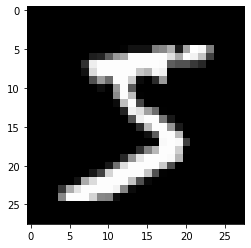

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28, 28), cmap='gray')
print(x_train.shape)

In [4]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

# x_train, x_train.shape, y_train.min(), y_train.max()

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad = True
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x -  x.exp().sum(-1).log().unsqueeze(-1)


def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-1.7577, -3.2081, -2.8602, -2.1872, -1.9082, -3.0157, -1.8505, -2.5975,
        -2.7881, -2.0628], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [21]:
yb = y_train[0:bs]
print(loss_func(preds, yb))
print(preds.shape, yb.shape)

tensor(2.3230, grad_fn=<NllLossBackward>)
torch.Size([64, 10]) torch.Size([64])


In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [23]:
print(accuracy(preds, yb))

tensor(0.0781)


In [24]:
yb.shape

torch.Size([64])

In [25]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n -1) // bs+1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()

        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [26]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3745, grad_fn=<NllLossBackward>) tensor(0.0625)


In [27]:
from torch.nn import functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias


In [45]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [46]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.4274, grad_fn=<NllLossBackward>)


In [47]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.zero_()
    bias.zero_()

In [48]:
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [49]:
def fit():
    for epoch in epochs:
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [51]:
fit()

TypeError: 'int' object is not iterable

In [52]:
print(loss_func(model(xb), yb))

tensor(2.4274, grad_fn=<NllLossBackward>)


In [54]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n -1 ) // bs+1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()


print(loss_func(model(xb), yb))

tensor(2.2970, grad_fn=<NllLossBackward>)
tensor(0.0800, grad_fn=<NllLossBackward>)


In [56]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0832, grad_fn=<NllLossBackward>)


In [57]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


In [58]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3112)
1 tensor(0.3410)


In [60]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)


import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
        print(epoch, val_loss)


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2)
    )


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32442389919757847
1 0.3313654312193394


In [62]:
xb.size(1)

784

In [63]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cpu')